# Medical Image Processing with Python - Lung Vessel Segmentation

https://theaisummer.com/medical-image-python/


In [10]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from PIL import Image, ImageDraw
from scipy.spatial import ConvexHull
from skimage import measure

We clip the X-ray image to have an upper maximum range since the Hounsfield scale measuring X-ray absorption ranges from -1000 to 1000+.

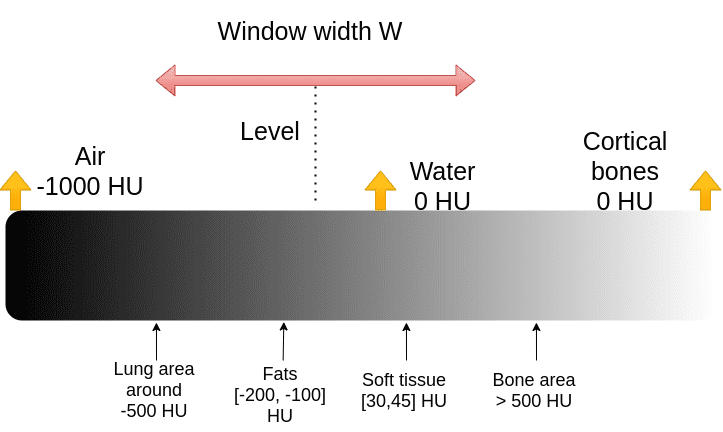

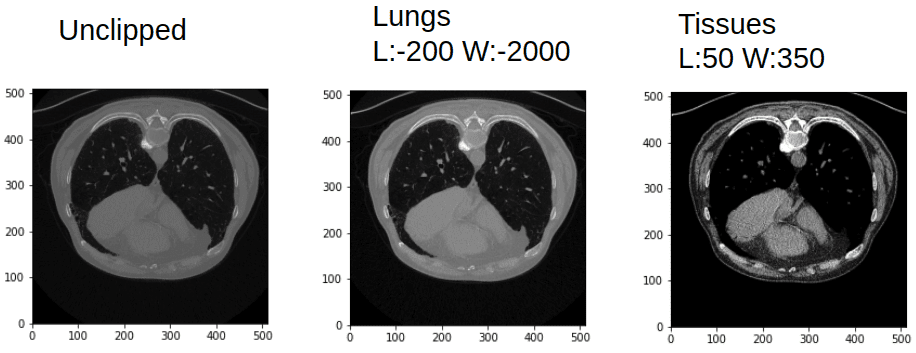

In [65]:
def show_slice_window(slice, level, window):
   """
   Function to display an image slice
   Input is a numpy 2D array
   """
   max = level + window/2
   min = level - window/2
   slice = slice.clip(min,max)
   plt.figure()
   plt.imshow(slice.T, cmap="gray", origin="lower")
   plt.savefig('L'+str(level)+'W'+str(window))

def show_slice(slice):
    """
    Function to display an image slice
    Input is a numpy 2D array
    """
    plt.figure()
    plt.imshow(slice.T, cmap="gray", origin="lower")

List of visualization ranges:

|Region/Tissue|Window|Level|
|-------------|------|-----|
|brain| 80 | 40 |
|lungs|	1500|	-600|
|liver|	150|	30|
|Soft tissues|	250	|50|
|bone|	1800|	400|

## Lung Segmentation Based on Intesity Values

Segmenting lungs and calculating area in $mm^2$.

First, we will need to find the real size of the pixel dimensions.

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  2 512 512   1   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.       0.677734 0.677734 0.7      1.       1.       1.       1.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 175.161
qoffset_y       : 306.661
qoffset_z       : -109.

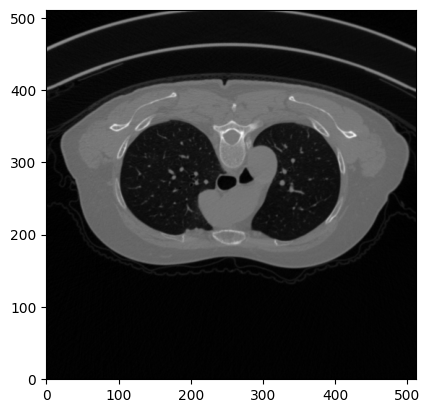

In [90]:
ct_img = nib.load("CT-images/slice001.nii.gz")
ct_numpy = ct_img.get_fdata()
print(ct_img.header)
show_slice(ct_numpy)

### Find pixel dimensions to calculate the area in mm^2

Define a function that reads information from the header file and determines the 2 dimension indices of the image and their respective pix dimensions.

In [91]:
def find_pix_dim(ct_img):
    """
    Get the pixdim of the CT image.
    A general solution that gets the pixdim indicated from the image dimensions. From the last 2 image dimensions, we get their pixel dimension.
    Args:
        ct_img: nib image

    Returns: List of the 2 pixel dimensions
    """
    pix_dim = ct_img.header["pixdim"] # example [1,2,1.5,1,1]
    dim = ct_img.header["dim"] # example [1,512,512,1,1]
    max_indx = np.argmax(dim)
    pixdimX = pix_dim[max_indx]
    dim = np.delete(dim, max_indx)
    pix_dim = np.delete(pix_dim, max_indx)
    max_indy = np.argmax(dim)
    pixdimY = pix_dim[max_indy]
    return [pixdimX, pixdimY] # example [2, 1.5]

In [92]:
pix_dim = find_pix_dim(ct_img)
pix_dim

[0.677734, 0.677734]

### Binarize image using intensity thresholding

We need to clip the Housendfield unit range to [-1000, -300] and binarize the values to 0 and 1. 

In [93]:
def intensity_seg(ct_numpy, min=-1000, max=-300):
    clipped = ct_numpy.clip(min, max)
    clipped[clipped != max] = 1
    clipped[clipped == max] = 0
    return measure.find_contours(clipped, 0.95)

In [118]:
contours = intensity_seg(ct_numpy)

### Find the lung area from a set of possible contours

In [95]:
def contour_distance(contour):
    """
    Given a set of points that may describe a contour
     it calculates the distance between the first and the last point
     to infer if the set is closed.
    Args:
        contour: np array of x and y points

    Returns: euclidean distance of first and last point
    """
    dx = contour[0, 1] - contour[-1, 1]
    dy = contour[0, 0] - contour[-1, 0]
    return np.sqrt(np.power(dx, 2) + np.power(dy, 2))

def set_is_closed(contour):
    if contour_distance(contour) < 1:
        return True
    else:
        return False

def find_lungs(contours):
    """
    Chooses the contours that correspond to the lungs and the body
    First, we exclude non-closed sets-contours
    Then we assume some min area and volume to exclude small contours
    Then the body is excluded as the highest volume closed set
    The remaining areas correspond to the lungs
    Args:
        contours: all the detected contours

    Returns: contours that correspond to the lung area
    """
    body_and_lung_contours = []
    vol_contours = []

    for contour in contours:
        hull = ConvexHull(contour)

       # set some constraints for the volume
        if hull.volume > 2000 and set_is_closed(contour):
            body_and_lung_contours.append(contour)
            vol_contours.append(hull.volume)

    # Discard body contour
    if len(body_and_lung_contours) == 2:
        return body_and_lung_contours
    elif len(body_and_lung_contours) > 2:
        vol_contours, body_and_lung_contours = (list(t) for t in
                zip(*sorted(zip(vol_contours, body_and_lung_contours))))
        body_and_lung_contours.pop(-1) # body is out!
    return body_and_lung_contours # only lungs left !!!

def show_contour(image, contours, name=None, save=False):
    fig, ax = plt.subplots()
    ax.imshow(image.T, cmap=plt.cm.gray)
    for contour in contours:
        ax.plot(contour[:, 0], contour[:, 1], linewidth=1)

    ax.set_xticks([])
    ax.set_yticks([])

    if save:
        plt.savefig(name)
        plt.close(fig)
    else:
        plt.show()

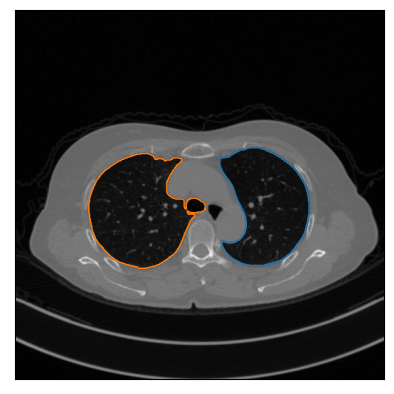

In [96]:
lungs = find_lungs(contours)
show_contour(ct_numpy, lungs, name='slice001', save=False)

We can see two contours (orange and blue) 

### Contour to binary mask

In [97]:
def create_mask_from_polygon(image, contours):
    """
    Creates a binary mask with the dimensions of the image and
    converts the list of polygon-contours to binary masks and merges them together
    Args:
        image: the image that the contours refer to
        contours: list of contours

    Returns:

    """
    lung_mask = np.array(Image.new('L', image.shape, 0))
    for contour in contours:
        x = contour[:, 0]
        y = contour[:, 1]
        polygon_tuple = list(zip(x, y))
        img = Image.new('L', image.shape, 0)
        ImageDraw.Draw(img).polygon(polygon_tuple, outline=0, fill=1)
        mask = np.array(img)
        lung_mask += mask

    lung_mask[lung_mask > 1] = 1  # sanity check to make 100% sure that the mask is binary
    return lung_mask.T  # transpose it to be aligned with the image dims

# Save the mask as nifty
def save_nifty(img_np, name, affine):
    """
    binary masks should be converted to 255 so it can be displayed in a nii viewer
    we pass the affine of the initial image to make sure it exits in the same
    image coordinate space
    Args:
        img_np: the binary mask
        name: output name
        affine: 4x4 np array
    Returns:
    """
    img_np[img_np == 1] = 255
    ni_img = nib.Nifti1Image(img_np, affine)
    nib.save(ni_img, name + '.nii.gz')

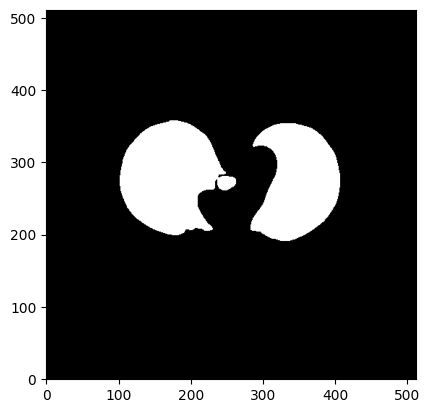

In [98]:
lung_mask = create_mask_from_polygon(ct_numpy, lungs)
show_slice(lung_mask)

We were able to extract the contours from the image and create the binary mask.

### Segment the main vessels and compute the vessels over lung area ratio

If there is a pixel with an intensity value over -500 HU inside the lung area then we will consider it as a vessel.

In [99]:
def euclidean_dist(dx, dy):
    return np.sqrt(np.power(dx, 2) + np.power(dy, 2))

def denoise_vessels(lung_contour, vessels):
    vessels_coords_x, vessels_coords_y = np.nonzero(vessels)  # get non zero coordinates
    for contour in lung_contour:
        x_points, y_points = contour[:, 0], contour[:, 1]
        for (coord_x, coord_y) in zip(vessels_coords_x, vessels_coords_y):
            for (x, y) in zip(x_points, y_points):
                d = euclidean_dist(x - coord_x, y - coord_y)
                if d <= 0.1:
                    vessels[coord_x, coord_y] = 0
    return vessels

def create_vessel_mask(lung_mask, lungs_contour, ct_numpy, denoise=False):
    vessels = lung_mask * ct_numpy  # isolate lung area
    vessels[vessels == 0] = -1000
    vessels[vessels >= -500] = 1
    vessels[vessels < -500] = 0
    show_slice(vessels)
    if denoise:
        return denoise_vessels(lungs_contour, vessels)
    return vessels

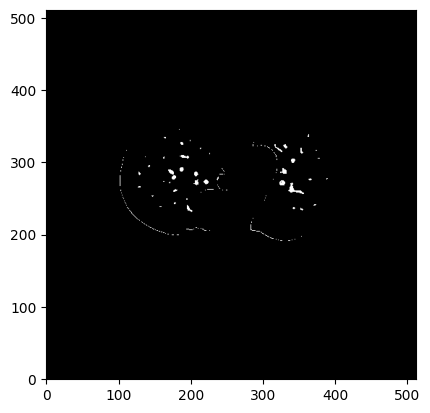

In [104]:
vessels = create_vessel_mask(lung_mask, lungs, ct_numpy, denoise=False)

We set denoise=False and were able to segment the lung vessels but still see some of the contour of the lungs. Let's use the denoise_vessels function to extract only the vessels.

In [105]:
vessels_only = denoise_vessels(lungs, vessels)

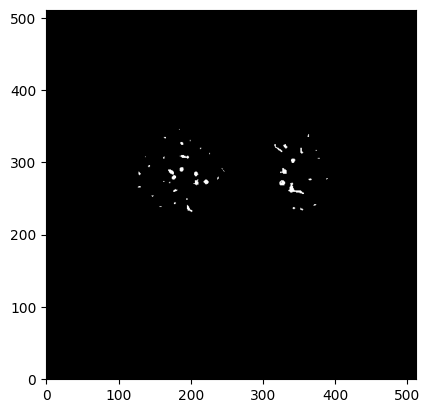

In [106]:
show_slice(vessels_only)

We can see the differencce between the intitial mask and denoise image. The contour of the lungs have been removed and we are left with the lung vessels only.

### Overlay the Mask

In [107]:
def overlay_plot(im, mask):
    plt.figure()
    plt.imshow(im.T, 'gray', interpolation='none')
    plt.imshow(mask.T, 'jet', interpolation='none', alpha=0.5)

Let's see what we get if we verlay the mask in the original image.

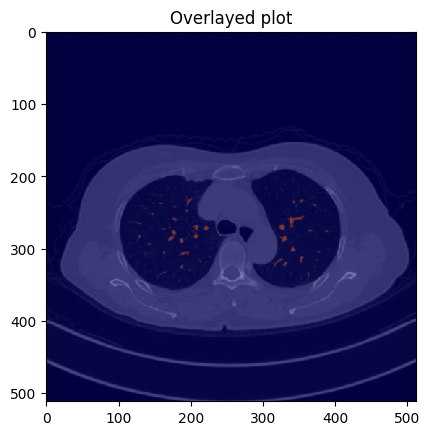

In [108]:
overlay_plot(ct_numpy, vessels_only)
plt.title('Overlayed plot')
plt.show()

We were able to segment the vessels (orange overlay) from inside the contour of the lungs. Let's compute the area and ratio of vessel area to lung area.

### Compute the area

In [109]:
def compute_area(mask, pixdim):
    """
    Computes the area (number of pixels) of a binary mask and multiplies the pixels
    with the pixel dimension of the acquired CT image
    Args:
        lung_mask: binary lung mask
        pixdim: list or tuple with two values

    Returns: the lung area in mm^2
    """
    mask[mask >= 1] = 1
    lung_pixels = np.sum(mask)
    return lung_pixels * pixdim[0] * pixdim[1]

In [112]:
lung_area = compute_area(lung_mask, find_pix_dim(ct_img))
vessel_area = compute_area(vessels_only, find_pix_dim(ct_img))
ratio = (vessel_area / lung_area) * 100
print("Slice001", 'Lung Area:', lung_area, 'mm^2')
print("Slice001", 'Vessel Area:', vessel_area, 'mm^2')
print("Slice001", 'Vessel %:', ratio)

Slice001 Lung Area: 14218.815117879074 mm^2
Slice001 Vessel Area: 319.2297618208411 mm^2
Slice001 Vessel %: 2.2451221087995865


The lung vessels take up 2.245% of the lung area.